In [48]:
import os
import operator

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from clickhouse_driver import Client

client = Client('localhost', database="thesisproxyheapsizedb")

In [49]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)

print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()

# We do not have heap size in the config, so add it manually.
records = list()
for e in exp_df.exp_id.unique():
	for p in e.split("_"):
		if "MBheap" in p:
			heap_size_mb = int(p.replace("MBheap", ""))
			records.append({
				"exp_id": e,
				"heap_size_mb": heap_size_mb,
			})
exp_df = exp_df.merge(pd.DataFrame.from_records(records))

pprint(exp_df.columns)
print()
exp_df

22
thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_coap_https
thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_dtls_https
thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client
thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy_

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_coap_https   
5                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_dtls_https   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_coap_https   
9                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_dtls_https   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_coap_https   
13                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_dtls_https   
14   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
17   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_coap_https   
19                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_dtls_https   
20   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0        100mbps                 256                        0            8   
1        100mbps                 256                        0            8   
2        100mbps                 256                        0            8   
3        100mbps                 256                        0            8   
4        100mbps                 256                        0            8   
5        100mbps                 256                        0            8   
6        100mbps                 256                        0            8   
7        100mbps                 256       

In [50]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))
proxy_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("proxy"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))
attacker_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("attacker"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{proxy_dnids=}")
print(f"{client_node_ids=}")
print(f"{attacker_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 182, 183, 184, 185, 186, 187, 188, 189, 194, 195, 196, 197, 198, 199, 200, 201, 206, 207, 208, 209, 210, 211, 212, 213, 218, 219, 220, 221, 222, 223, 224, 225, 230, 231, 232, 233, 234, 235, 236, 237, 242, 243, 244, 245, 246, 247, 248, 249, 254, 255, 256, 257, 258, 259, 260, 261}
attacker_dnids={1, 133, 13, 145, 25, 157, 37, 169, 49, 181, 61, 193, 73, 205, 85, 217, 97, 229, 109, 241, 121, 253}
proxy_dnids={131, 263, 11, 143, 23, 155, 35, 167, 47, 179, 59, 1

In [51]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' 'bad_gateway' '']


exp_id  \
0        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
1230942   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1230943   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1230944   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1230945   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1230946   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

         trial observer_id  message_marker response_code  send_time_sec  \
0            1     client1               1       content       0.000000   
1            1     client1               2       content       0.396844   
2            1     client1               3       content       0.457773   
3            1     client1               4       content       0.519089   
4            1     client1               5       content       0.578183   
...        ...         ...             ...           ...            ...   
1230942      5     client8          705407       content     125.438349   
1230943      5     client8          705408       content     125.491878   
1230944      5     client8          705409       content     125.545332   
1230945      5     client8          705410       content     125.598869   
1230946      5     client8          705411                   125.652417   

         recv_time_sec  first_send_time_sec  last_send_time_sec  \
0             0.381186             0.000000            0.000000   
1             0.455831             0.396844            0.396844   
2             0.516893             0.457773            0.457773   
3             0.575833             0.519089            0.519089   
4             0.634519             0.578183            0.578183   
...                ...                  ...                 ...   
1230942     125.491084           125.438349          125.438349   
1230943     125.544506           125.491878          125.491878   
1230944     125.598054           125.545332          125.545332   
1230945     125.651609           125.598869          125.598869   
1230946       0.000000           125.652417          125.652417   

         first_recv_time_sec  ...  num_proxy_connections  request_timeout  \
0                   0.381186  ...                     50                5   
1                   0.455831  ...                     50                5   
2                   0.516893  ...                     50                5   
3                   0.575833  ...                     50                5   
4                   0.634519  ...                     50                5   
...                      ...  ...                    ...              ...   
1230942           125.491084

In [52]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 2.58 s, sys: 448 ms, total: 3.03 s
Wall time: 3.67 s


exp_id  \
0        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
1236462   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1236463   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1236464   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1236465   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1236466   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

         observe_timestamp  trial observer_id  message_marker  \
0                 0.000000      1     client1               1   
1                 0.396844      1     client1               2   
2                 0.457773      1     client1               3   
3                 0.519089      1     client1               4   
4                 0.578183      1     client1               5   
...                    ...    ...         ...             ...   
1236462         125.438349      5     client8          705407   
1236463         125.491878      5     client8          705408   
1236464         125.545332      5     client8          705409   
1236465         125.598869      5     client8          705410   
1236466         125.652417      5     client8          705411   

         coap_retransmitted  
0                     False  
1                     False  
2                     False  
3                     False  
4                     False  
...                     ...  
1236462               False  
1236463               False  
1236464               False  
1236465               False  
1236466               False  

[1236467 rows x 6 columns]

In [53]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content' 'bad_gateway']
CPU times: user 3.16 s, sys: 1.13 s, total: 4.28 s
Wall time: 4.94 s


exp_id  \
0        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
1229969   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229970   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229971   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229972   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229973   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

         observe_timestamp  trial observer_id  message_marker response_code  \
0                 0.381186      1     client1               1       content   
1                 0.455831      1     client1               2       content   
2                 0.516893      1     client1               3       content   
3                 0.575833      1     client1               4       content   
4                 0.634519      1     client1               5       content   
...                    ...    ...         ...             ...           ...   
1229969         125.437553      5     client8          705406       content   
1229970         125.491084      5     client8          705407       content   
1229971         125.544506      5     client8          705408       content   
1229972         125.598054      5     client8          705409       content   
1229973         125.651609      5     client8          705410       content   

         successful_message  
0                      True  
1                      True  
2                      True  
3                      True  
4                      True  
...                     ...  
1229969                True  
1229970                True  
1229971                True  
1229972                True  
1229973                True  

[1229974 rows x 7 columns]

In [54]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 36 ms, sys: 3.36 ms, total: 39.3 ms
Wall time: 146 ms


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
435   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
436   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
437   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
438   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
439   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial   observer_id         metric_type    avg_value  min_value  \
0        1  originserver     cpu_utilization     5.438571        0.4   
1        1         proxy     cpu_utilization    16.111429        0.5   
2        1  originserver  memory_utilization   283.457851      261.0   
3        1         proxy  memory_utilization  4197.317726      259.0   
4        2  originserver     cpu_utilization     5.285000        0.4   
..     ...           ...                 ...          ...        ...   
435      4         proxy  memory_utilization  3648.215000      259.0   
436      5  originserver     cpu_utilization     5.288571        0.5   
437      5         proxy     cpu_utilization    16.010000        0.4   
438      5  originserver  memory_utilization   283.945455      262.0   
439      5         proxy  memory_utilization  3727.527454      259.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         22.2       100mbps                 256                        0   
1         90.4       100mbps                 256                        0   
2        296.0       100mbps                 256                        0   
3       7063.0       100mbps                 256                        0   
4         22.5       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
435     6006.0       100mbps                 256                        0   
436       22.5       100mbps                 256                        0   
437       87.2       100mbps                 256                        0   
438      309.0       100mbps                 256                        0   
439     6112.0       100mbps                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
435  ...                     50                5            2   
436  ..

In [55]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 5.97 s, sys: 431 µs, total: 5.97 s
Wall time: 5.97 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
875   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
876   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
877   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
878   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
879   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  num_messages  num_successful_messages   mean_rps  \
0        1     client1          1574                     1567  13.058333   
1        1     client2          1585                     1579  13.158333   
2        1     client3          1583                     1577  13.141667   
3        1     client4          1578                     1573  13.108333   
4        1     client5          1584                     1578  13.150000   
..     ...         ...           ...                      ...        ...   
875      5     client4          1563                     1557  12.975000   
876      5     client5          1569                     1565  13.041667   
877      5     client6          1564                     1560  13.000000   
878      5     client7          1572                     1567  13.058333   
879      5     client8          1568                     1562  13.016667   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          1                          6     360.723801   
1                          1                          6     342.388081   
2                          2                          6     382.778461   
3                          1                          6     341.619355   
4                          1                          6     358.057115   
..                       ...                        ...            ...   
875                        1                          6     346.030334   
876                        1                          6     346.663609   
877                        3                          5     632.662160   
878                        1                          7     319.212959   
879                        2                          8     362.166457   

     min_rtt_ms  ...  num_proxy_connections  request_timeout  max_retries  \
0     51.570892  ...                     50                5            2   
1     51.586866  ...                     50                5            2   
2     51.476955  ...                     50                5            2   
3     51.650047  ...                     50                5            2   
4     51.528931  ...                     50                5            2   
..          ...  ...                    ...          

In [56]:
### Dev plotting

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

In [57]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

value_map_replacement = {
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    False: "CoAP",
    "dtls": "CoAPS",
    True: "CoAPS",
  },
  "reuse_connections": {
    "reuse-connections": "Reuse Connections",
    True: "Reuse Connections",
    "no-connection-reuse": "No Connection Reuse",
    False: "No Connection Reuse",
  },
  "run_attacker": {
    "attacker": "With Attacker",
    True: "With Attacker",
    "no-attacker": "Without Attacker",
    False: "Without Attacker",
  },
  "response_code": {
    "bad_gateway": "Bad Gateway",
    "content": "Content",
  },
}

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

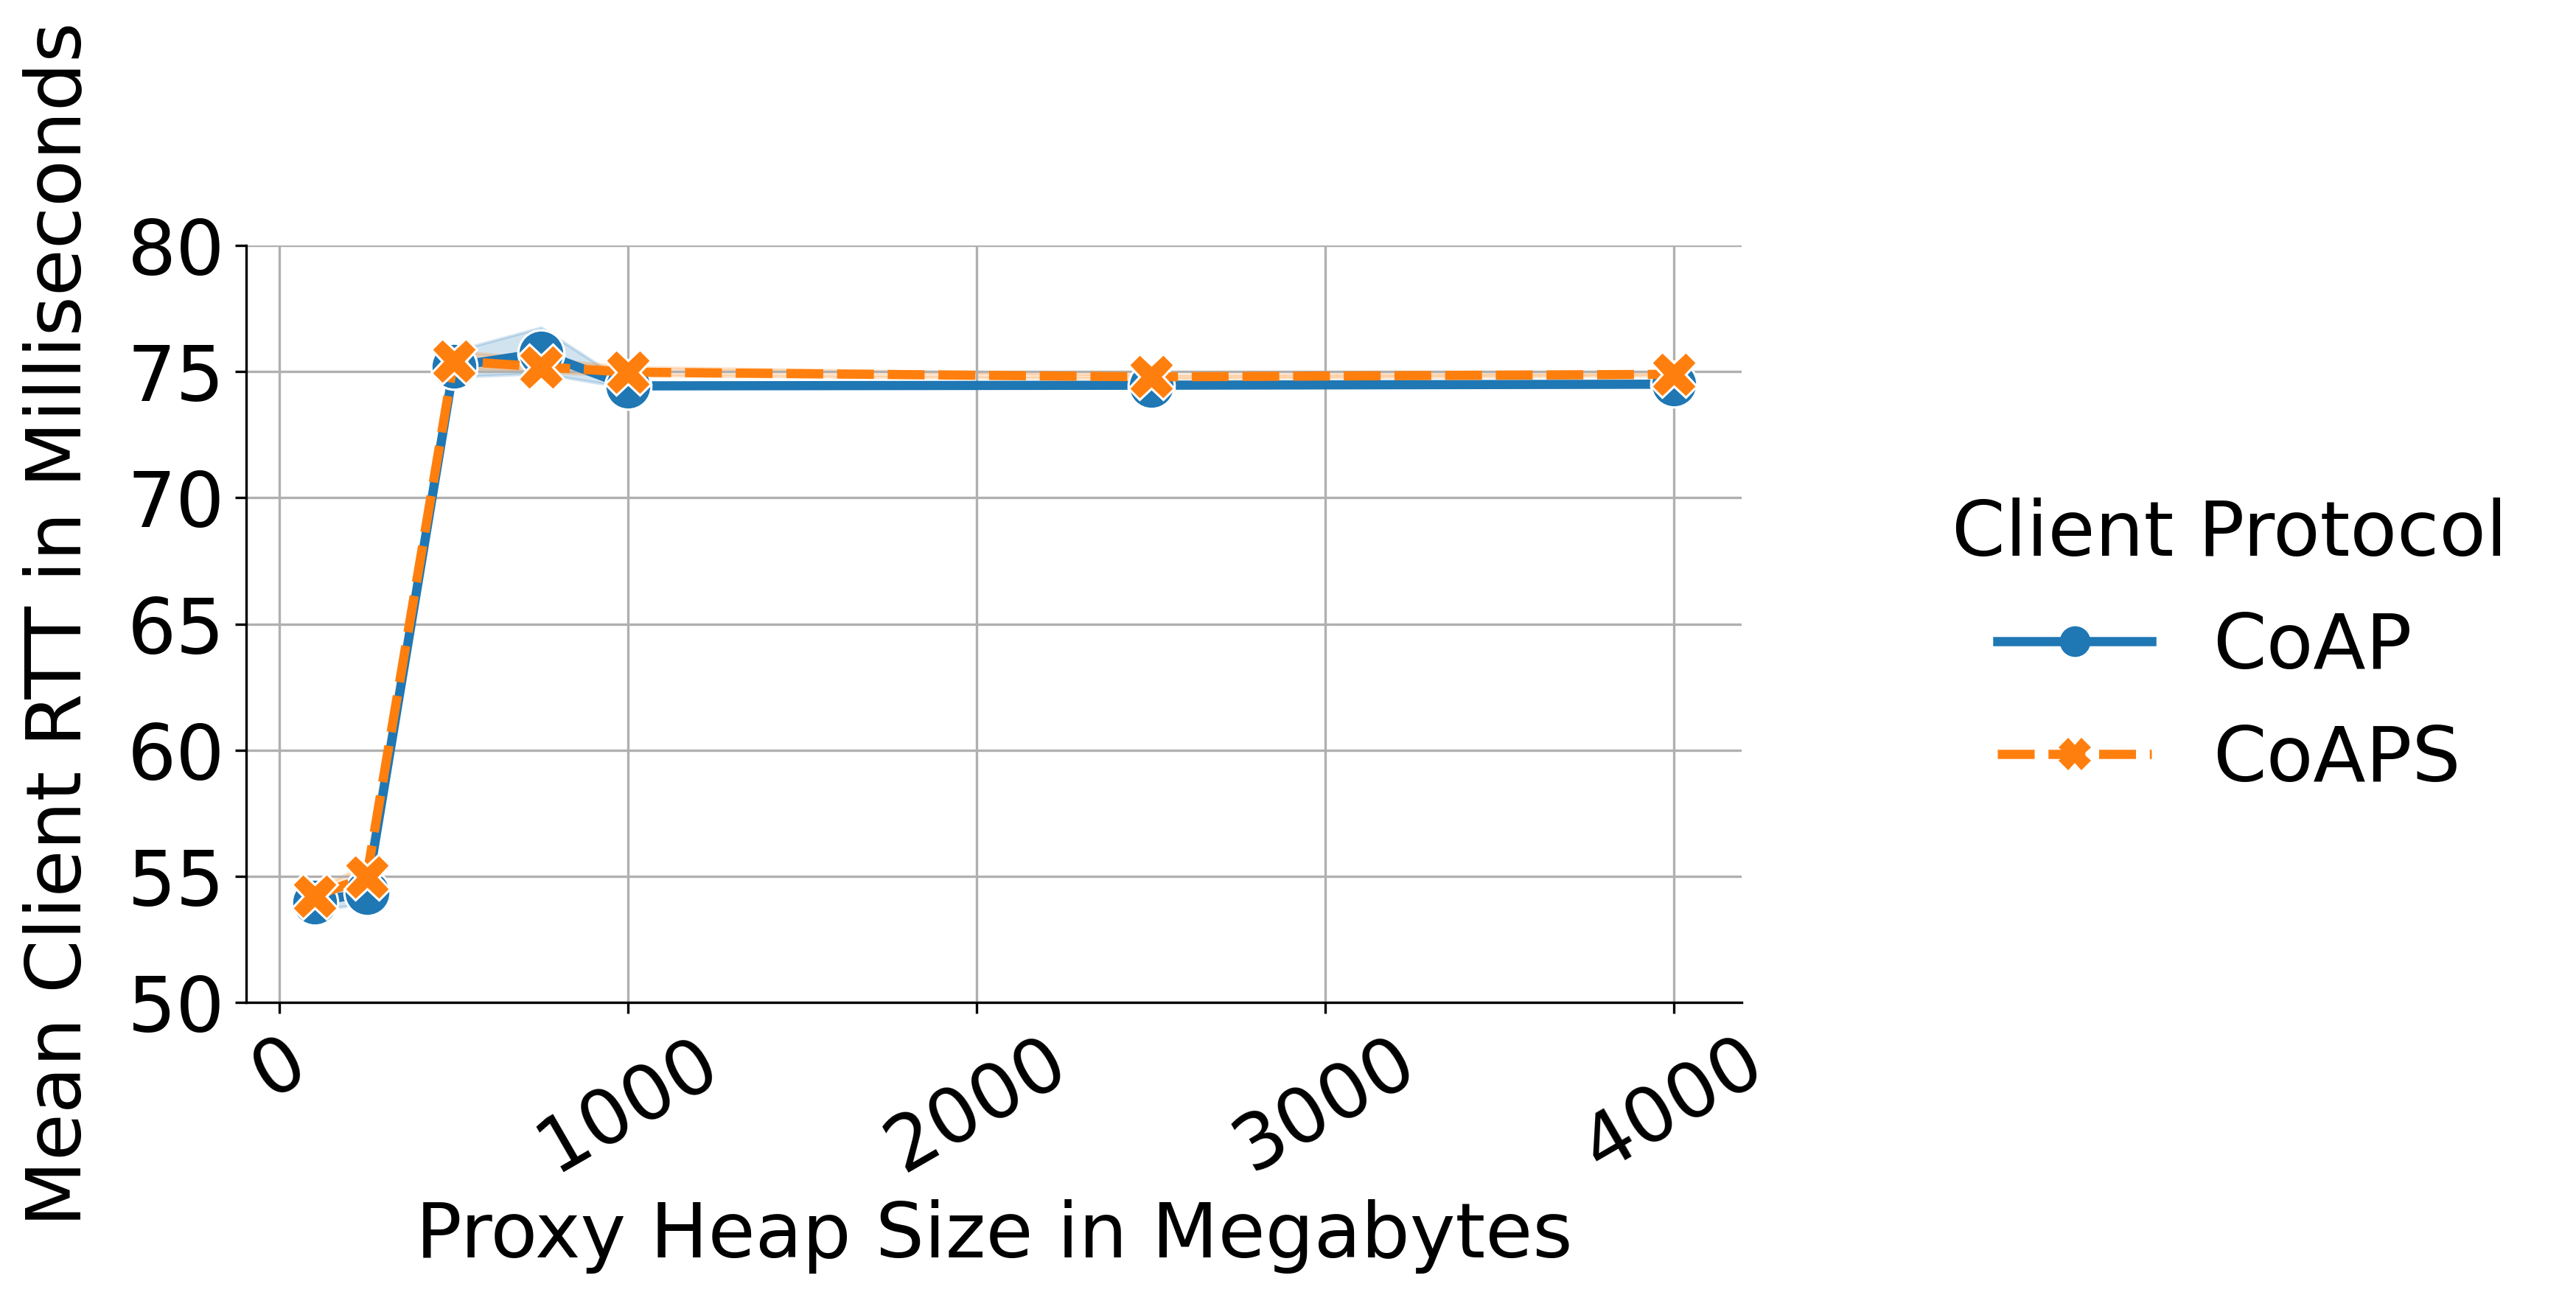

mean_rtt_ms
heap_size_mb run_proxy_with_dtls             
100          CoAP                   53.989603
             CoAPS                  54.214957
250          CoAP                   54.354593
             CoAPS                  54.966166
500          CoAP                   75.211675
             CoAPS                  75.424153
750          CoAP                   75.730796
             CoAPS                  75.188403
1000         CoAP                   74.433723
             CoAPS                  74.978358
2500         CoAP                   74.460552
             CoAPS                  74.792192
4000         CoAP                   74.501313
             CoAPS                  74.891756

In [97]:
### Plot effect of RTT as a result of increasing number of clients

df = client_rps_df
df = df[df["heap_size_mb"] <= 5000]

g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="mean_rtt_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  aspect=1.75,
)

g.legend.set_title("Client Protocol")
g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Mean Client RTT in Milliseconds", labelpad=10)
g.set(
  # xticks=np.arange(0,10001,1000),
  yticks=np.arange(50,81,5),
)

plt.grid(True, axis="both")
plt.xticks(rotation=30)
plt.show()

(
  df
  .groupby(
    by=["heap_size_mb", "run_proxy_with_dtls"]
  )
  .agg(
    mean_rtt_ms=("mean_rtt_ms", "mean")
  )
)

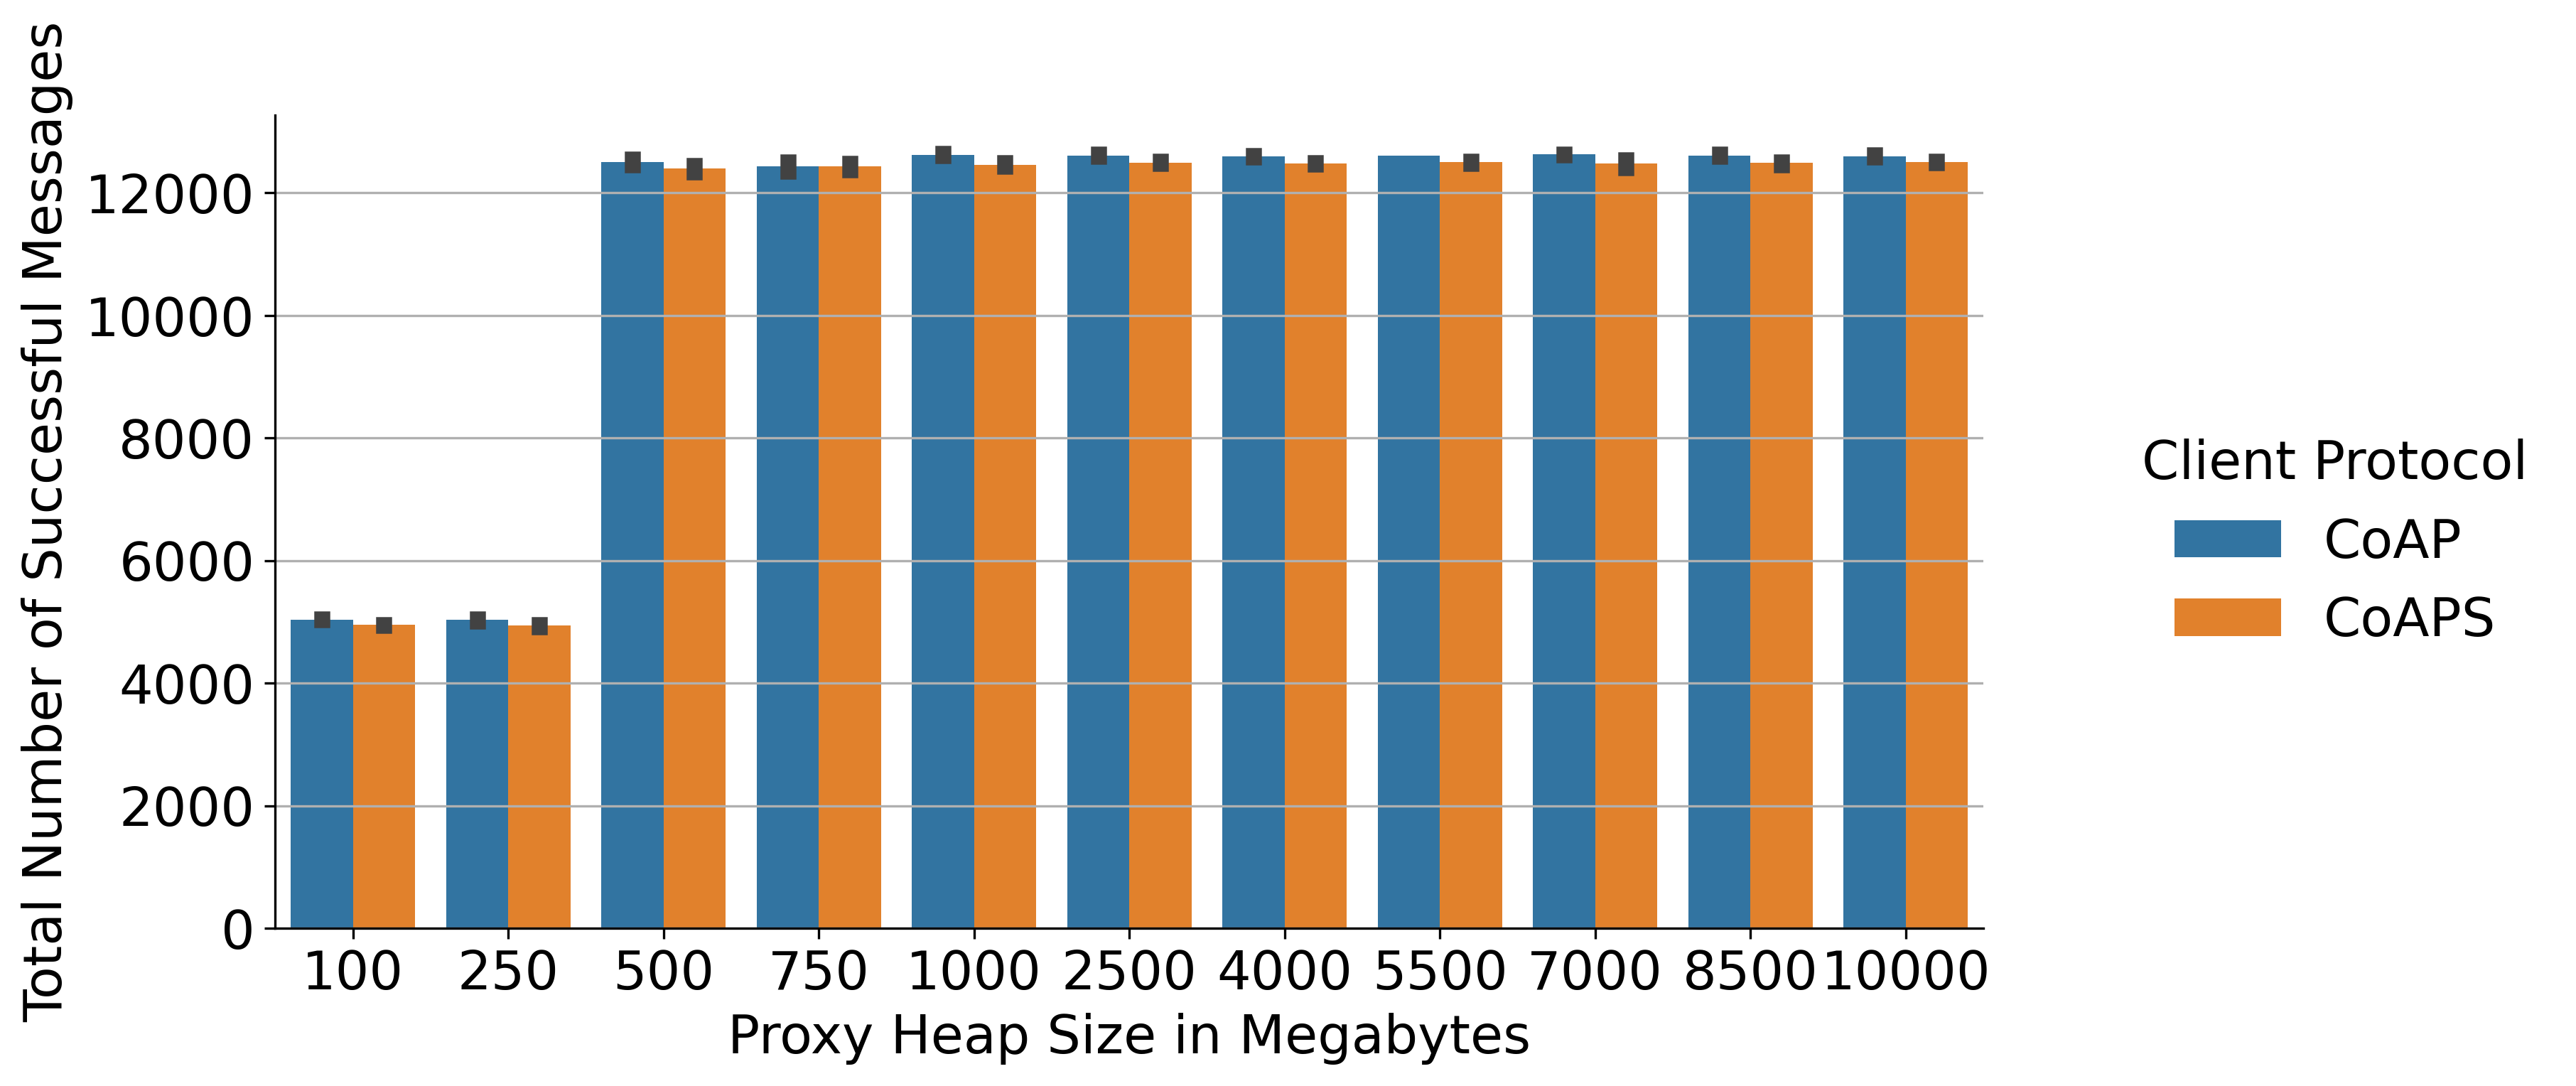

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_coap_https   
5                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_dtls_https   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_coap_https   
9                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_dtls_https   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_coap_https   
13                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_dtls_https   
14   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
17   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_coap_https   
19                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_dtls_https   
20   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  mean_total_successful_messages  \
0                 CoAP            8                         12602.6   
1                CoAPS            8                         12504.0   
2                 CoAP            8                         12616.4   
3                CoAPS            8                         12462.0   
4                 CoAP            8                          5038.8   
5                CoAPS            8                          4951.6   
6                 CoAP            8                         12611.4   
7                CoAPS            8                         12493.8   
8                 CoAP      

In [59]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "heap_size_mb", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  aspect=2,
)

g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients"])
  .agg(
    mean_total_successful_messages=("total_successful_messages", "mean"),
  )
  .reset_index()
)
_df["mean_successful_messages_per_client"] = _df["mean_total_successful_messages"] / _df["num_clients"]
_df

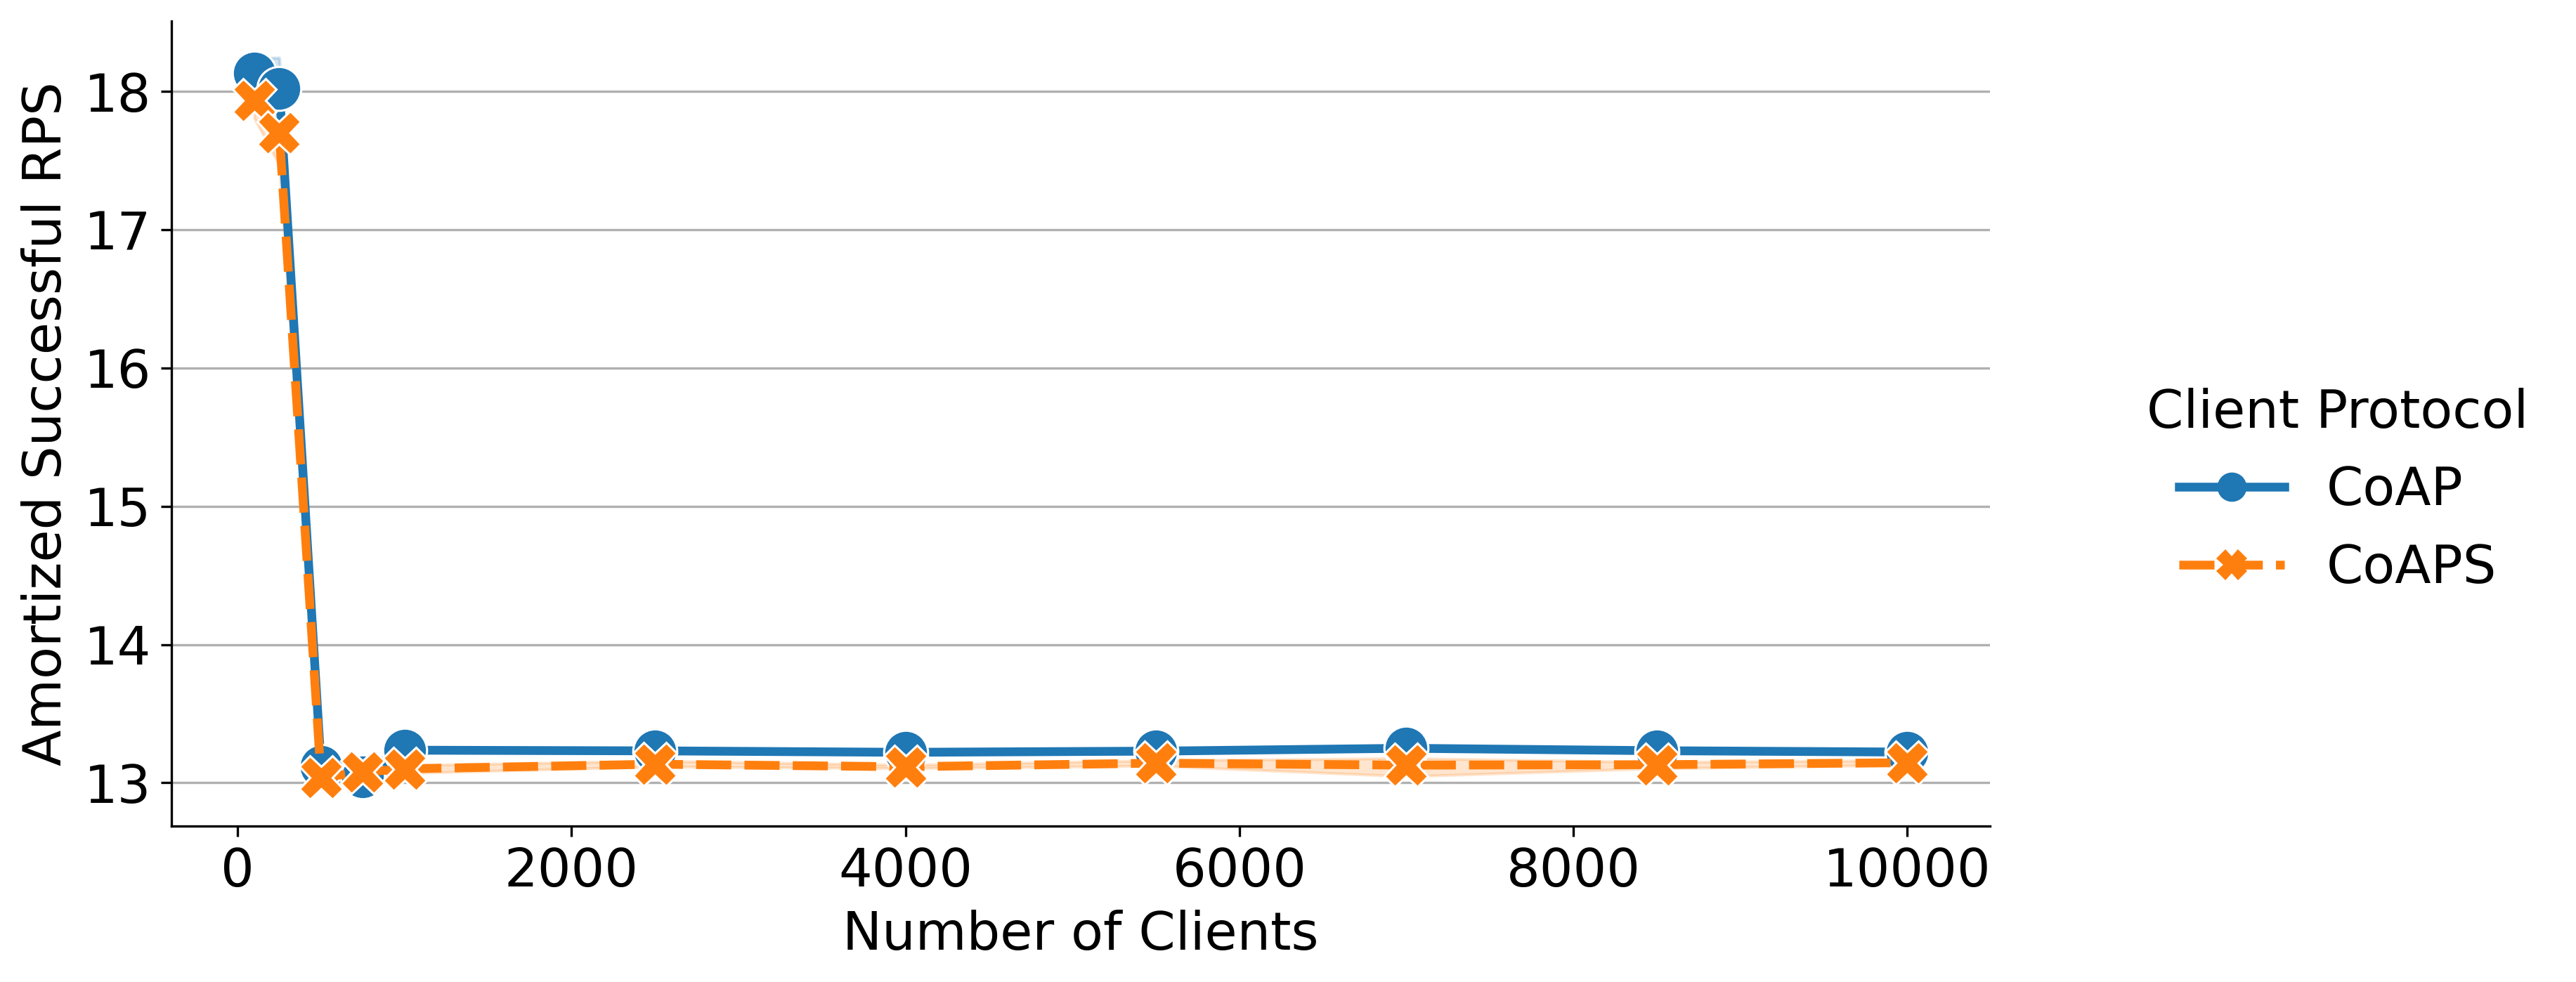

exp_id  \
0   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1   thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
4                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_coap_https   
5                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_dtls_https   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
8                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_coap_https   
9                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_dtls_https   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
12                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_coap_https   
13                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_dtls_https   
14   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
15   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
17   thesis_group_controlling_proxy_heap_size_8clients_withattacker_7000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
18                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_coap_https   
19                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_dtls_https   
20   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
21   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

   run_proxy_with_dtls  num_clients  heap_size_mb  \
0                 CoAP            8         10000   
1                CoAPS            8         10000   
2                 CoAP            8          1000   
3                CoAPS            8          1000   
4                 CoAP            8           100   
5                CoAPS            8           100   
6                 CoAP            8          2500   
7                CoAPS            8          2500   
8                 CoAP            8           250   
9                CoAPS            8           250   
10                CoAP            8          4000   
11               CoAPS         

In [60]:
g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "heap_size_mb"])
  .agg(
    mean_amortized_successful_rps=("amortized_successful_rps", "mean"),
  )
  .reset_index()
)
_df["mean_amortized_rps_messages_per_client"] = _df["mean_amortized_successful_rps"] / _df["num_clients"]
_df

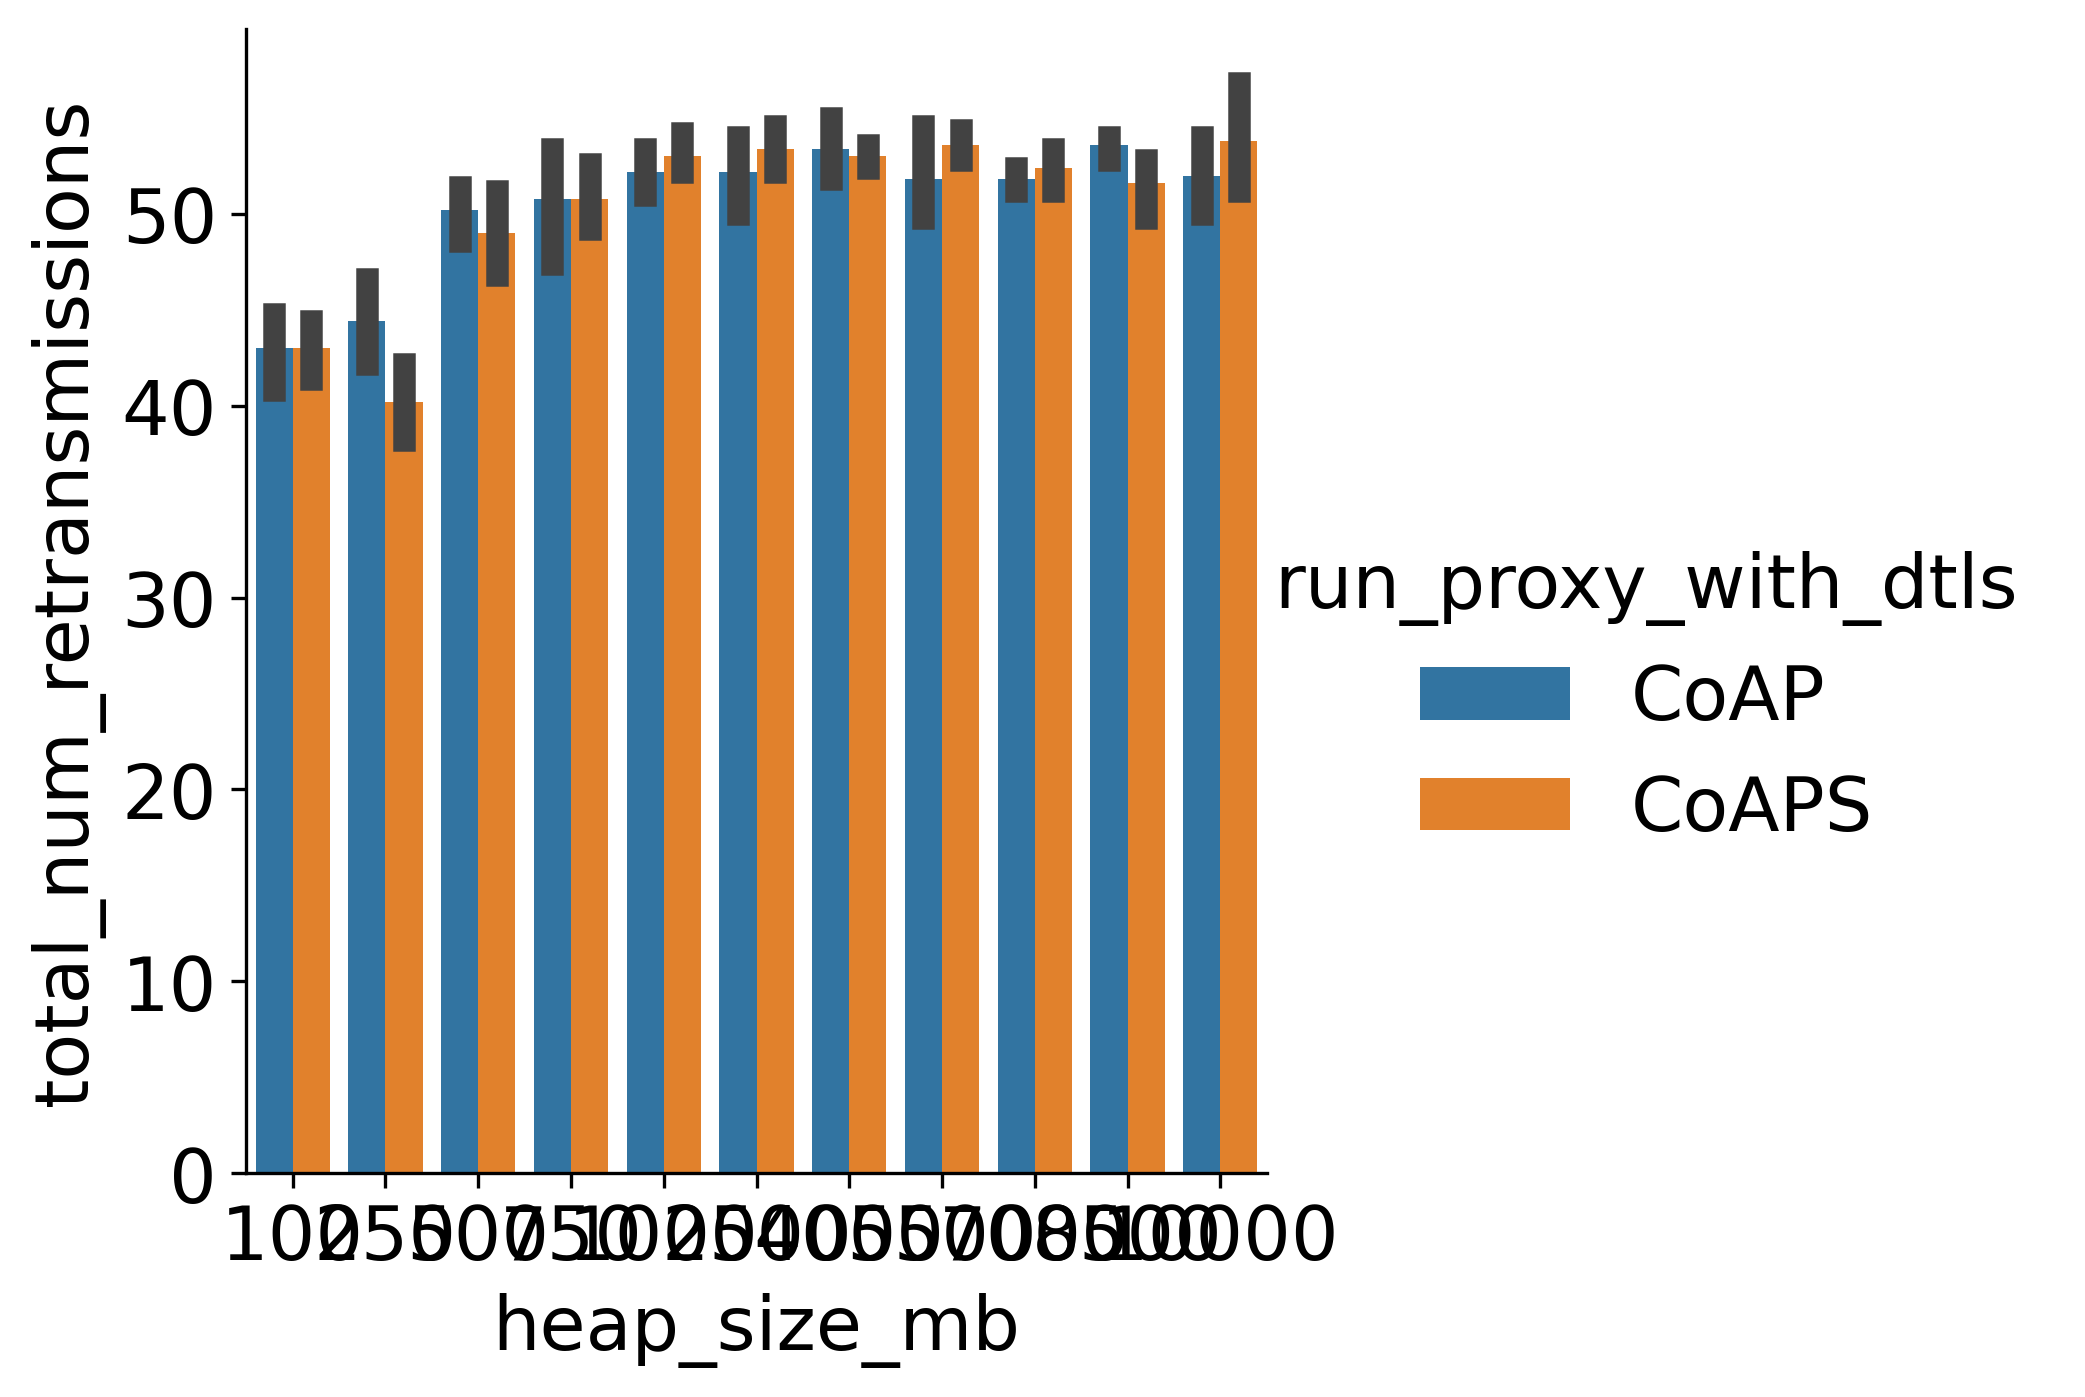

exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
105   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
106   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
107   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
108   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
109   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial  num_clients run_proxy_with_dtls  heap_size_mb  \
0        1            8                CoAP         10000   
1        2            8                CoAP         10000   
2        3            8                CoAP         10000   
3        4            8                CoAP         10000   
4        5            8                CoAP         10000   
..     ...          ...                 ...           ...   
105      1            8               CoAPS          8500   
106      2            8               CoAPS          8500   
107      3            8               CoAPS          8500   
108      4            8               CoAPS          8500   
109      5            8               CoAPS          8500   

     total_num_retransmissions  
0                           49  
1                           53  
2                           55  
3                           54  
4                           49  
..                         ...  
105                         53  
106                         52  
107                         52  
108                         48  
109                         53  

[110 rows x 6 columns]

In [61]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls", "heap_size_mb"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="total_num_retransmissions",
  hue="run_proxy_with_dtls",
)
plt.show()

df[df["total_num_retransmissions"] > 0]

In [62]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 4.17 s, sys: 245 ms, total: 4.41 s
Wall time: 4.41 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
875   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
876   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
877   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
878   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
879   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1573                    1567   
1        1     client2                    1584                    1580   
2        1     client3                    1582                    1577   
3        1     client4                    1577                    1575   
4        1     client5                    1583                    1579   
..     ...         ...                     ...                     ...   
875      5     client4                    1562                    1558   
876      5     client5                    1568                    1568   
877      5     client6                    1563                    1560   
878      5     client7                    1571                    1570   
879      5     client8                    1567                    1563   

    transaction_success_rate attacker_rate  server_connections  \
0                  99.618563       100mbps                 256   
1                  99.747475       100mbps                 256   
2                  99.683944       100mbps                 256   
3                  99.873177       100mbps                 256   
4                  99.747315       100mbps                 256   
..                       ...           ...                 ...   
875                99.743918       100mbps                 256   
876                    100.0       100mbps                 256   
877                99.808061       100mbps                 256   
878                99.936346       100mbps                 256   
879                99.744735       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                          0            8  ...                     50   
1                          0            8  ...                     50   
2                          0            8  ...                     50   
3                          0            8  ...                     50   
4                          0            8  ...                     50   
..                       ...          ...  ...                    ...   
875                        0            8  ...                     50   
876                        0            8  ...     

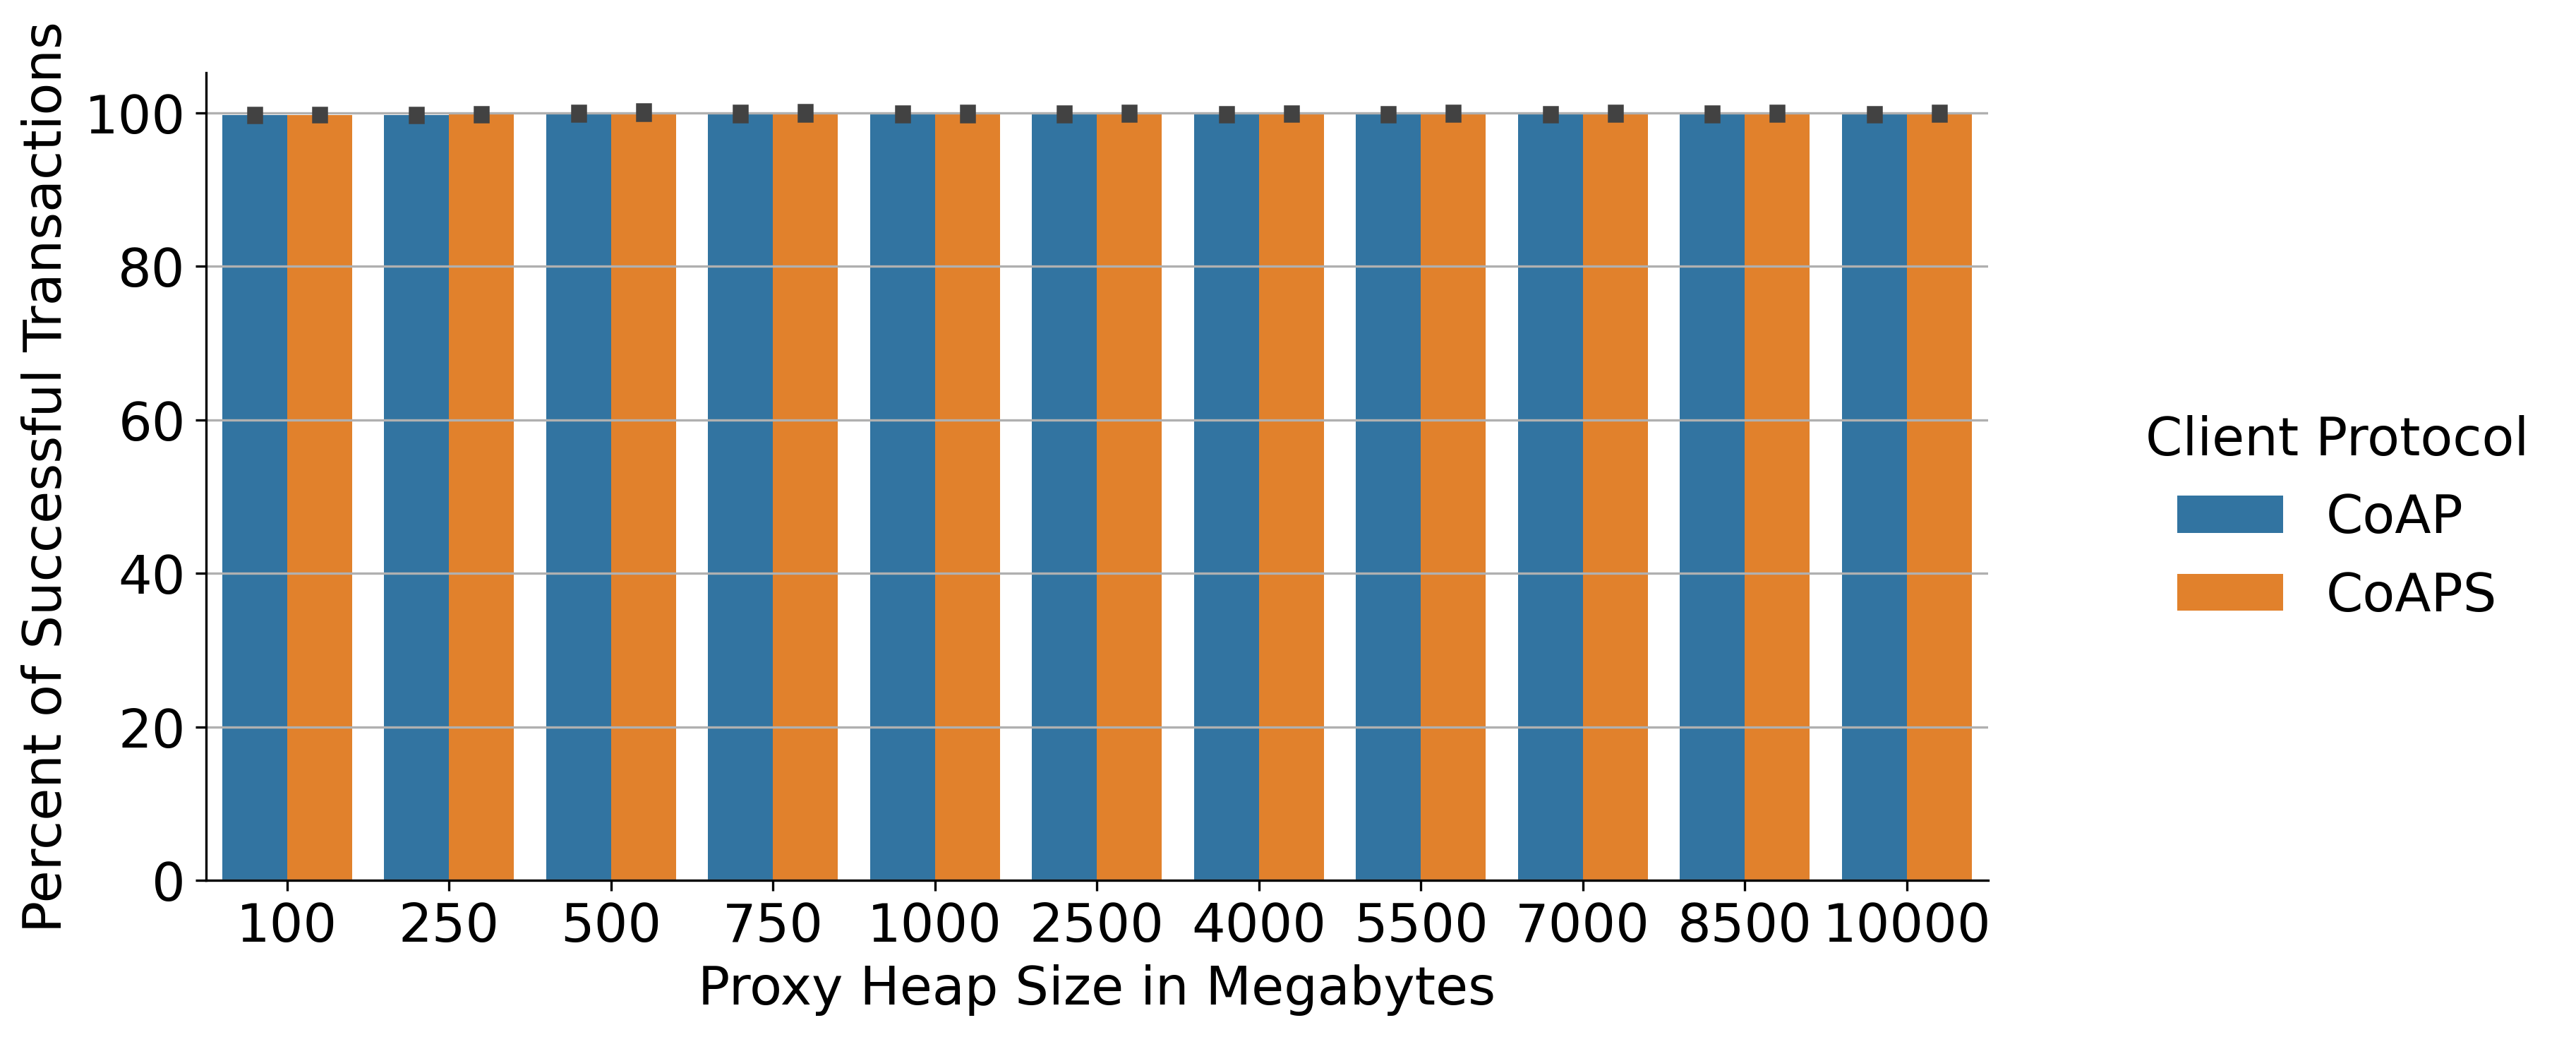

exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
873   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
875   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
877   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
878   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
879   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id  unique_message_markers num_successful_messages  \
0        1     client1                    1573                    1567   
1        1     client2                    1584                    1580   
2        1     client3                    1582                    1577   
3        1     client4                    1577                    1575   
4        1     client5                    1583                    1579   
..     ...         ...                     ...                     ...   
873      5     client2                    1563                    1561   
875      5     client4                    1562                    1558   
877      5     client6                    1563                    1560   
878      5     client7                    1571                    1570   
879      5     client8                    1567                    1563   

    transaction_success_rate attacker_rate  server_connections  \
0                  99.618563       100mbps                 256   
1                  99.747475       100mbps                 256   
2                  99.683944       100mbps                 256   
3                  99.873177       100mbps                 256   
4                  99.747315       100mbps                 256   
..                       ...           ...                 ...   
873                99.872041       100mbps                 256   
875                99.743918       100mbps                 256   
877                99.808061       100mbps                 256   
878                99.936346       100mbps                 256   
879                99.744735       100mbps                 256   

     max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                          0            8  ...                     50   
1                          0            8  ...                     50   
2                          0            8  ...                     50   
3                          0            8  ...                     50   
4                          0            8  ...                     50   
..                       ...          ...  ...                    ...   
873                        0            8  ...                     50   
875                        0            8  ...     

In [63]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="heap_size_mb",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

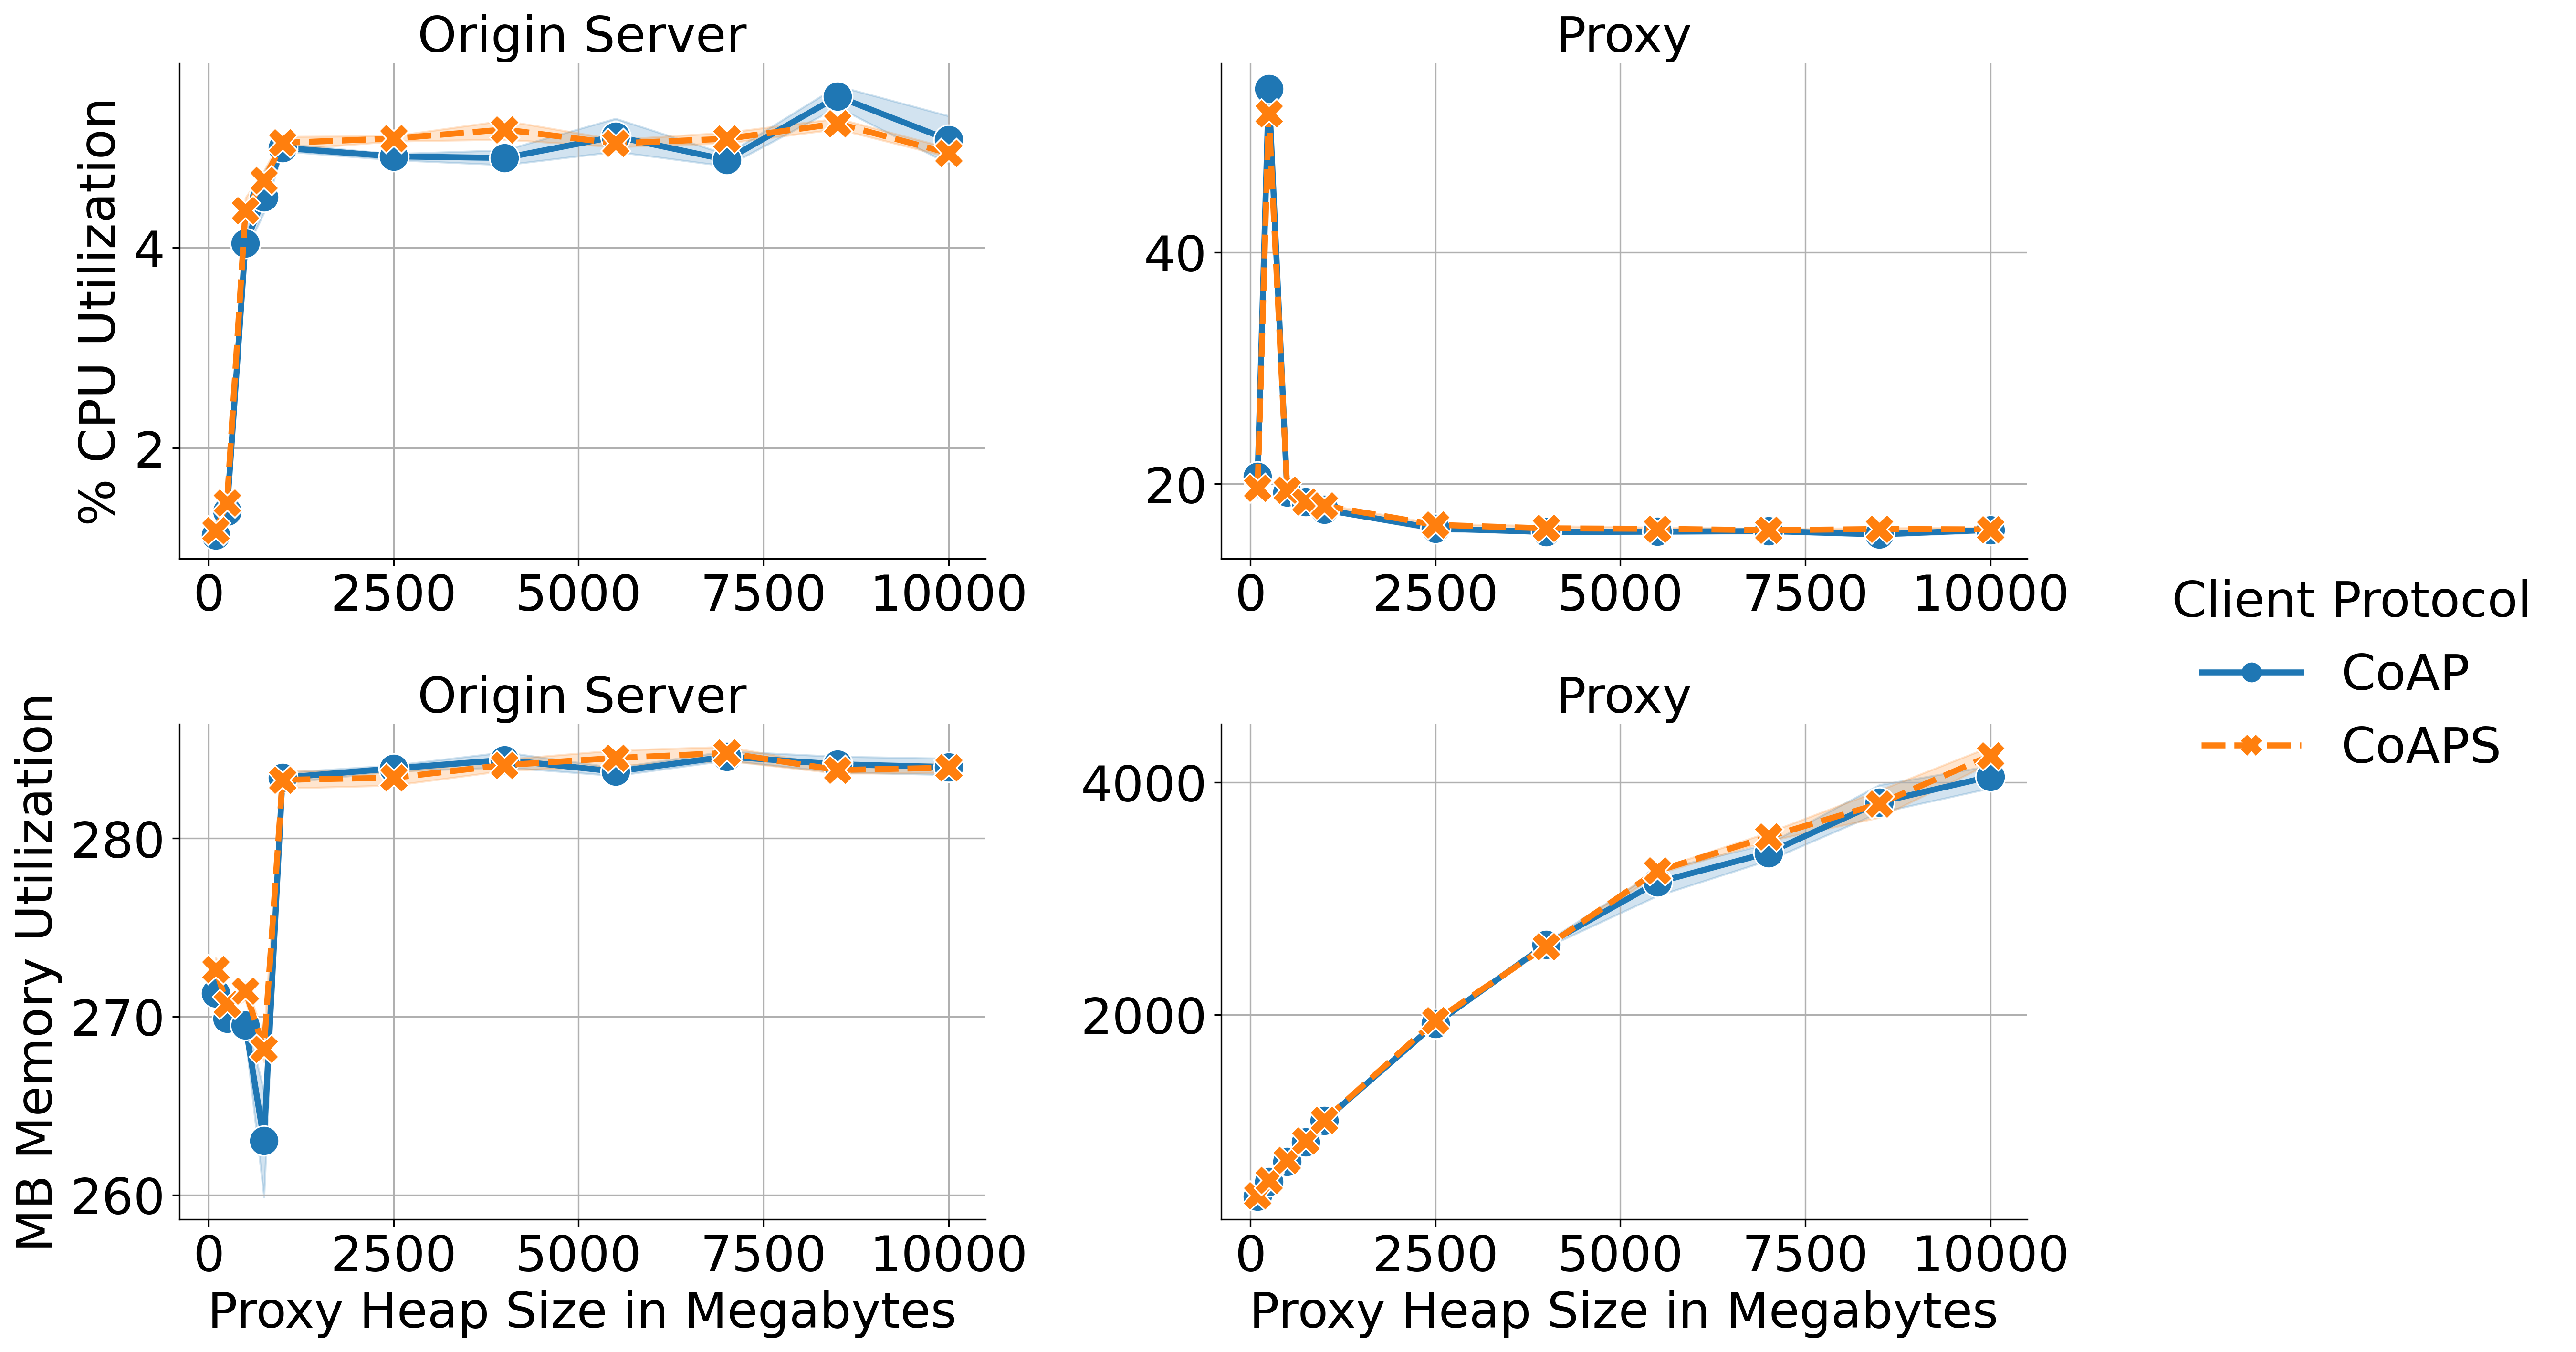

CPU times: user 5.05 s, sys: 254 ms, total: 5.3 s
Wall time: 4.99 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
435   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
436   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
437   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
438   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
439   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial    observer_id            metric_type    avg_value  min_value  \
0        1  Origin Server      % CPU Utilization     5.438571        0.4   
1        1          Proxy      % CPU Utilization    16.111429        0.5   
2        1  Origin Server  MB Memory Utilization   283.457851      261.0   
3        1          Proxy  MB Memory Utilization  4197.317726      259.0   
4        2  Origin Server      % CPU Utilization     5.285000        0.4   
..     ...            ...                    ...          ...        ...   
435      4          Proxy  MB Memory Utilization  3648.215000      259.0   
436      5  Origin Server      % CPU Utilization     5.288571        0.5   
437      5          Proxy      % CPU Utilization    16.010000        0.4   
438      5  Origin Server  MB Memory Utilization   283.945455      262.0   
439      5          Proxy  MB Memory Utilization  3727.527454      259.0   

     max_value attacker_rate  server_connections  max_keep_alive_requests  \
0         22.2       100mbps                 256                        0   
1         90.4       100mbps                 256                        0   
2        296.0       100mbps                 256                        0   
3       7063.0       100mbps                 256                        0   
4         22.5       100mbps                 256                        0   
..         ...           ...                 ...                      ...   
435     6006.0       100mbps                 256                        0   
436       22.5       100mbps                 256                        0   
437       87.2       100mbps                 256                        0   
438      309.0       100mbps                 256                        0   
439     6112.0       100mbps                 256                        0   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
435  ...                

In [89]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="avg_value",
  row="metric_type",
  col="observer_id",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
  aspect=1.5,
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Proxy Heap Size in Megabytes")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
# g.axes[0,0].set_ylim(0,4)
# g.axes[0,1].set_ylim(0,4)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")
# g.axes[1,0].set_ylim(250, 500)
# g.axes[1,1].set_ylim(250, 500)

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

plt.show()

df

In [65]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
# assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
# assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 3min 23s, sys: 7min 43s, total: 11min 6s
Wall time: 40.8 s


exp_id  \
0      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
11002   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
11003   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
11004   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
11005   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
11006   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

       trial observer_id   timestamp  cum_syn  cum_fin  open_connections  \
0          1       proxy    0.000000        0        0                 0   
1          1       proxy    0.064351        1        0                 1   
2          1       proxy    1.402079        2        0                 2   
3          1       proxy    2.127625        3        0                 3   
4          1       proxy    6.663204        4        0                 4   
...      ...         ...         ...      ...      ...               ...   
11002      5       proxy  126.059631       55       52                 3   
11003      5       proxy  126.381256       55       53                 2   
11004      5       proxy  129.278196       55       54                 1   
11005      5       proxy  131.205116       55       55                 0   
11006      5       proxy  140.000000       55       55                 0   

      attacker_rate  server_connections  max_keep_alive_requests  ...  \
0           100mbps                 256                        0  ...   
1           100mbps                 256                        0  ...   
2           100mbps                 256                        0  ...   
3           100mbps                 256                        0  ...   
4           100mbps                 256                        0  ...   
...             ...                 ...                      ...  ...   
11002       100mbps                 256                        0  ...   
11003       100mbps                 256                        0  ...   
11004       100mbps                 256                        0  ...   
11005       100mbps                 256                        0  ...   
11006       100mbps                 256                        0  ...   

       num_proxy_connections  request_timeout  max_retries  \
0                         50                5            2   
1                         50                5            2   
2                         50                5            2   
3                         50                5            2   
4                         50                5            2   
...                      ...              ...          ...   
11002                     50                5            2   
11003    

In [66]:
%%time

## Measure proxy and server connection management.

df = connections_df

plt.rcParams['font.size'] = '25'

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="heap_size_mb",
  col_wrap=2,
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Open Connections", labelpad=20)
g.legend.set_title("Client Protocol")
# g.set(yticks=np.arange(1,9,1))
# for i in range(8):
#   g.axes[i].grid(True, axis="both")

plt.show()

CPU times: user 17.5 s, sys: 604 ms, total: 18.1 s
Wall time: 17.8 s


In [67]:
%%time 

client_journey_sql = f"""
WITH client_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

client_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.observer_id AS observer_id,
  client_sends.trial AS trial,
  client_sends.message_marker AS message_marker,
  (groupArray(client_recvs.coap_code))[1] AS coap_code,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  abs(1e3 * (MIN(proxy_events.observe_timestamp) - MIN(client_sends.observe_timestamp))) AS client_to_proxy_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(proxy_events.observe_timestamp)) AS proxy_to_client_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS client_to_self_rtt_ms,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  client_sends
  JOIN proxy_events
    ON proxy_events.exp_id = client_sends.exp_id
    AND proxy_events.trial = client_sends.trial
    AND proxy_events.message_marker = client_sends.message_marker
  JOIN client_recvs
    ON client_recvs.exp_id = proxy_events.exp_id
    AND client_recvs.trial = proxy_events.trial
    AND client_recvs.message_marker = proxy_events.message_marker
    AND client_recvs.observer_id = client_sends.observer_id
GROUP BY
  client_sends.exp_id, client_sends.observer_id, client_sends.trial, client_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

client_journey_df = client.query_dataframe(client_journey_sql)

client_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_journey_df

CPU times: user 4.7 s, sys: 1.84 s, total: 6.55 s
Wall time: 2min 40s


exp_id  \
0        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4        thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                  ...   
1229952   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229953   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229954   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229955   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
1229956   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

        observer_id  trial  message_marker coap_code  first_send_time_sec  \
0           client1      1               1   content             0.000000   
1           client1      1               2   content             0.396844   
2           client1      1               3   content             0.457773   
3           client1      1               4   content             0.519089   
4           client1      1               5   content             0.578183   
...             ...    ...             ...       ...                  ...   
1229952     client8      5          705406   content           125.384795   
1229953     client8      5          705407   content           125.438349   
1229954     client8      5          705408   content           125.491878   
1229955     client8      5          705409   content           125.545332   
1229956     client8      5          705410   content           125.598869   

         client_to_proxy_ms  proxy_to_client_ms  client_to_self_rtt_ms  \
0                 20.619869          360.566139             381.186008   
1                 20.527124           38.460016              58.987141   
2                 20.575047           38.544893              59.119940   
3                 20.530939           36.212921              56.743860   
4                 20.592928           35.742998              56.335926   
...                     ...                 ...                    ...   
1229952           20.249128           32.508850              52.757978   
1229953           20.283937           32.451153              52.735090   
1229954           20.276070           32.351971              52.628040   
1229955           20.318985           32.402992              52.721977   
1229956           20.294905           32.444954              52.739859   

         first_recv_time_sec  
0                   0.381186  
1                   0.455831  
2                   0.516893  
3                   0.575833  
4                   0.634519  
...                      ...  
1229952           125.437553  
1229953           125.491084  
1229954           125.544506  
1229955           125.598054  
1229956           125.651609  

[1229957 rows x 10 columns]

In [68]:
%%time

# `client_journey_df` is far too detailed for plotting, but
# is useful for non-plotting use-cases so we keep it around.
# But for plotting, we summarize RTTs in discrete intervals
# of time instead, thus reducing the amount of data.

reduced_client_journey_df = (
  client_journey_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(client_journey_df["first_send_time_sec"], np.arange(0,121,5))
  ])
  .agg(
    client_to_proxy_ms=("client_to_proxy_ms", "mean"),
    proxy_to_client_ms=("proxy_to_client_ms", "mean"),
    client_to_self_rtt_ms=("client_to_self_rtt_ms", "mean"),
  )
  .reset_index()
  .melt(
    id_vars=["exp_id", "observer_id", "trial", "first_send_time_sec"],
    value_vars=["client_to_proxy_ms", "proxy_to_client_ms", "client_to_self_rtt_ms"],
    var_name="sub_journey_name",
    value_name="sub_journey_time_ms",
  )
)

reduced_client_journey_df["first_send_time_sec"] = reduced_client_journey_df["first_send_time_sec"].map(operator.attrgetter("right"))
reduced_client_journey_df = reduced_client_journey_df.merge(exp_df, on="exp_id", how="left")

reduced_client_journey_df

CPU times: user 1.27 s, sys: 2.48 ms, total: 1.28 s
Wall time: 1.27 s


exp_id  \
0      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4      thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
63355   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63356   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63357   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63358   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63359   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
0         client1      1                   5     client_to_proxy_ms   
1         client1      1                  10     client_to_proxy_ms   
2         client1      1                  15     client_to_proxy_ms   
3         client1      1                  20     client_to_proxy_ms   
4         client1      1                  25     client_to_proxy_ms   
...           ...    ...                 ...                    ...   
63355     client8      5                 100  client_to_self_rtt_ms   
63356     client8      5                 105  client_to_self_rtt_ms   
63357     client8      5                 110  client_to_self_rtt_ms   
63358     client8      5                 115  client_to_self_rtt_ms   
63359     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms attacker_rate  server_connections  \
0                20.546628       100mbps                 256   
1                20.494136       100mbps                 256   
2                20.521948       100mbps                 256   
3                20.502270       100mbps                 256   
4                20.504408       100mbps                 256   
...                    ...           ...                 ...   
63355            52.239757       100mbps                 256   
63356            52.526584       100mbps                 256   
63357            52.486904       100mbps                 256   
63358            52.694759       100mbps                 256   
63359            52.537462       100mbps                 256   

       max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
0                            0            8  ...                     50   
1                            0            8  ...                     50   
2                            0            8  ...                     50   
3                            0            8  ...                     50   
4                            0            8  ...                     50   
...                        ...          ...  ...                    ...   
63355                        0            8  ...                     50   
63356                        0            8  ...                     50  

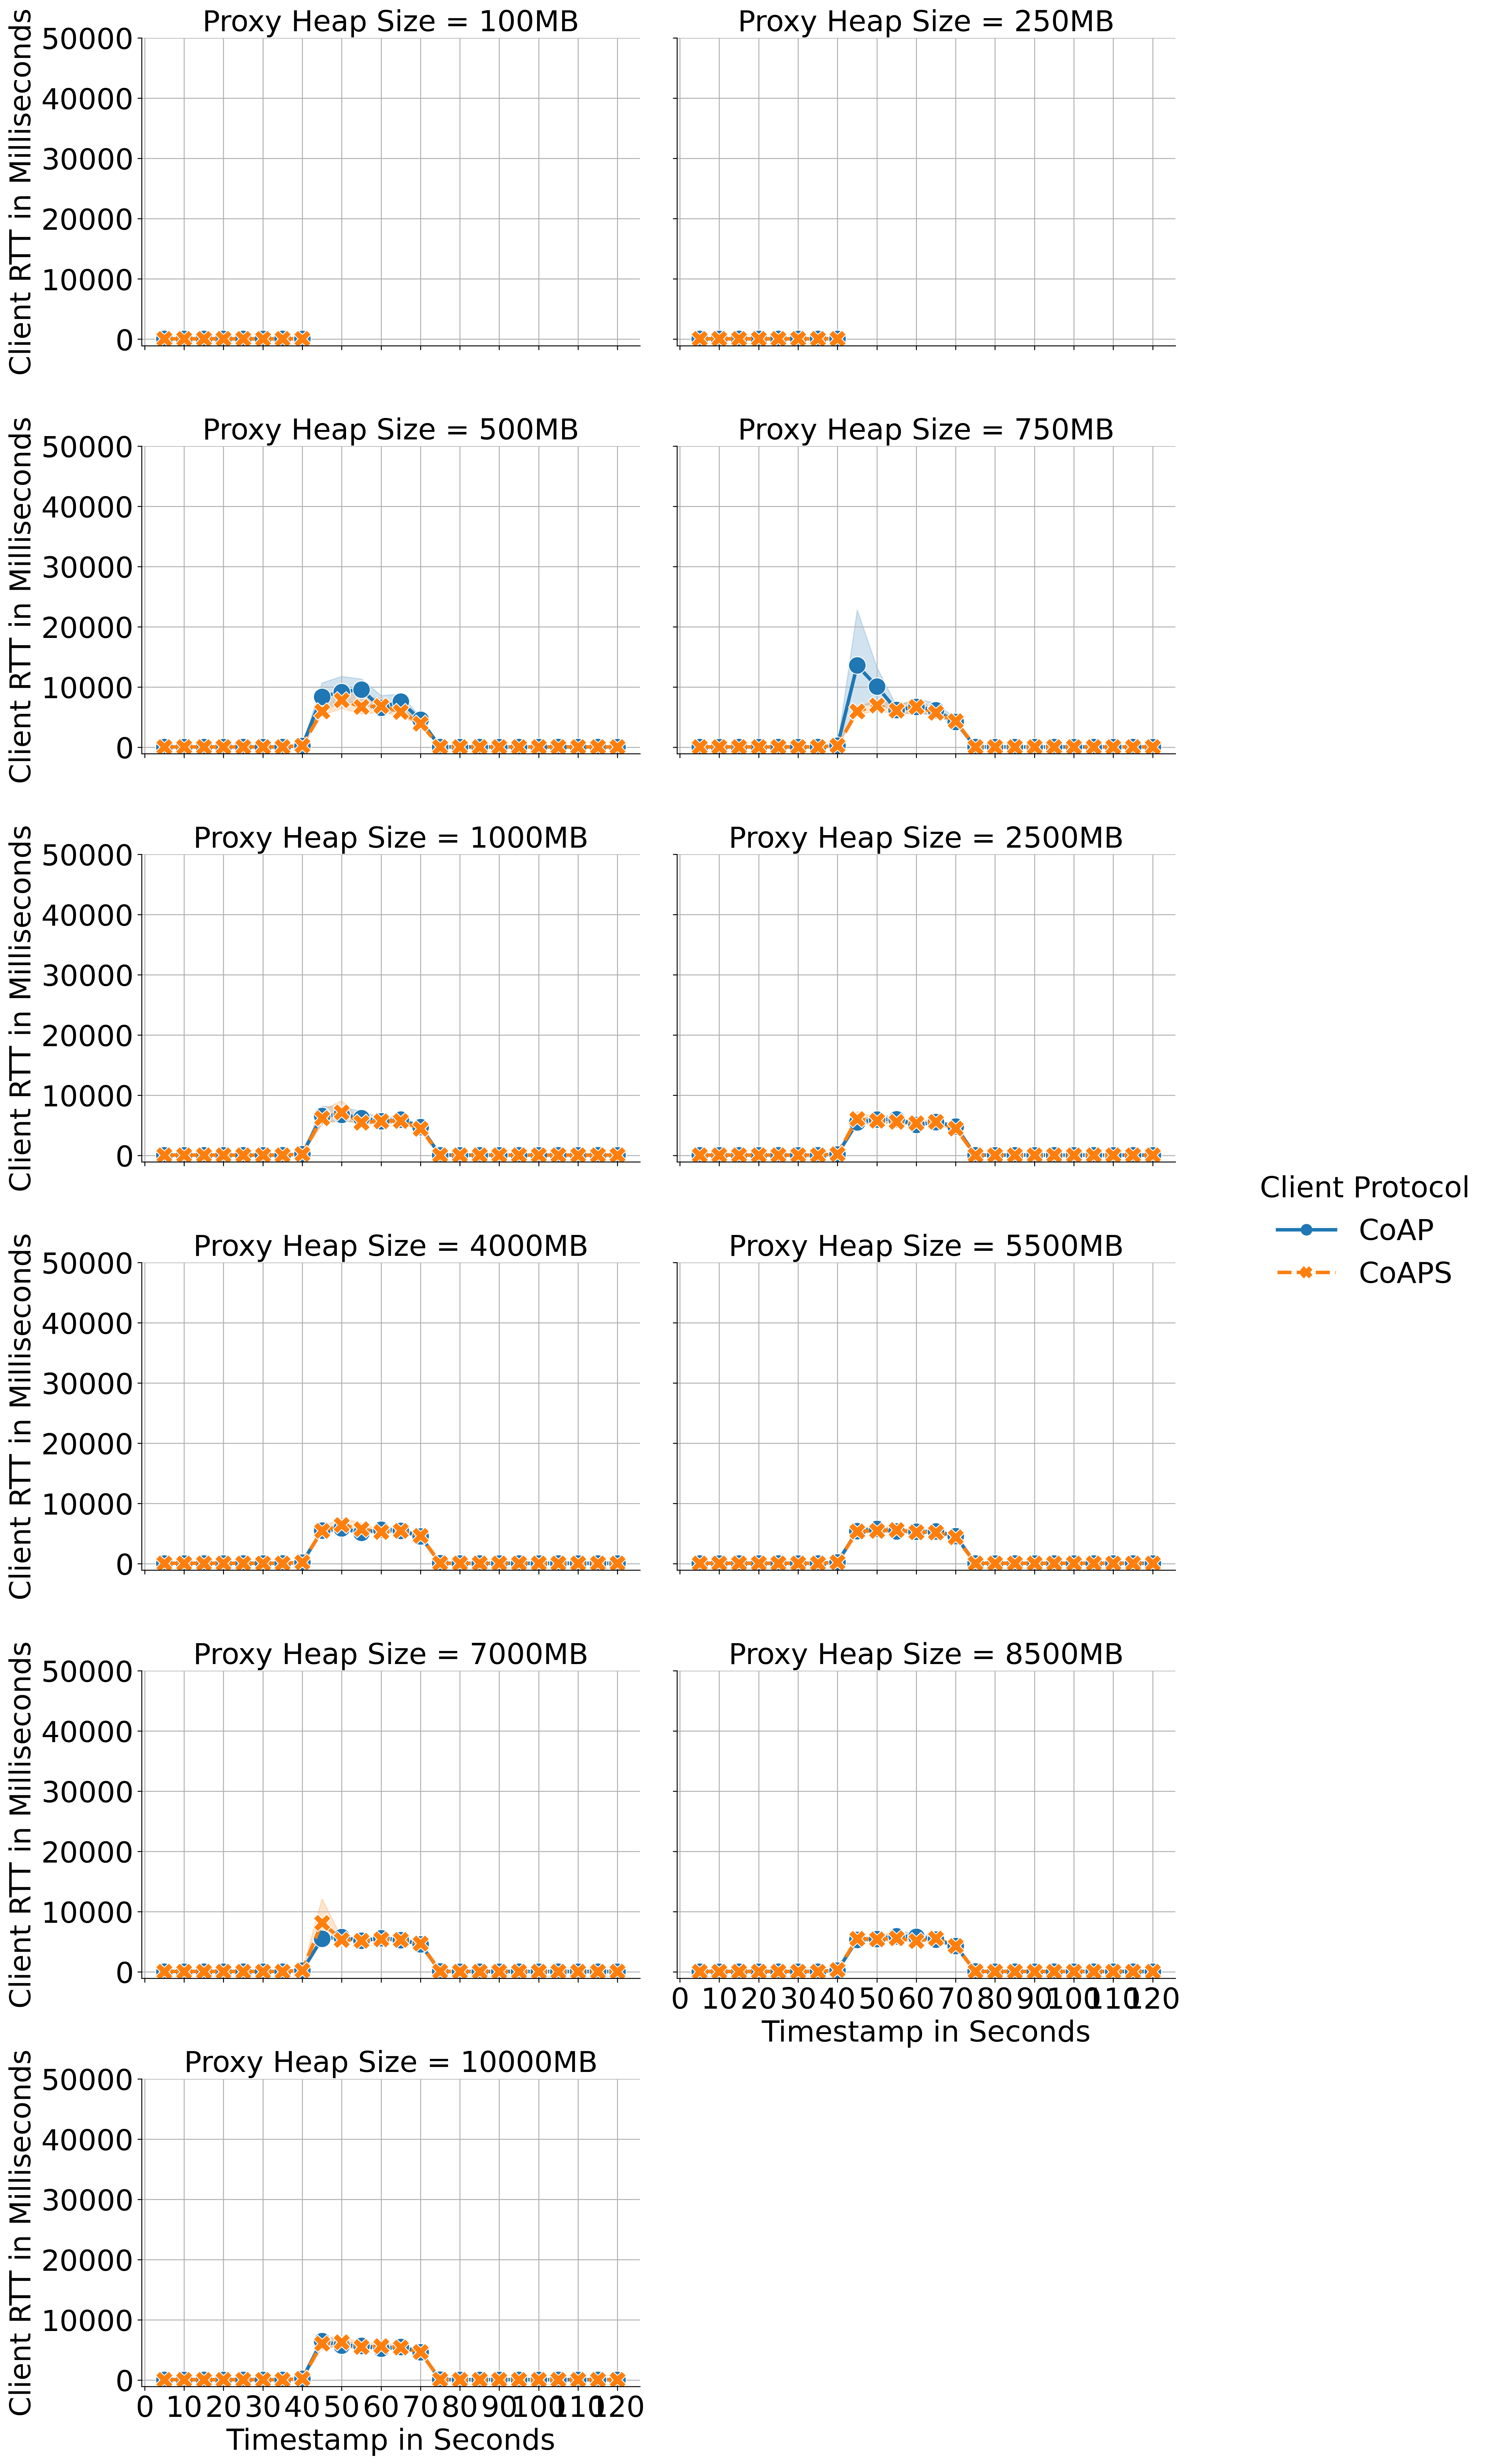

CPU times: user 19.5 s, sys: 587 ms, total: 20 s
Wall time: 19.7 s


exp_id  \
42240  thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
42241  thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
42242  thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
42243  thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
42244  thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
...                                                                                                                                                ...   
63355   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63356   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63357   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63358   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
63359   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

      observer_id  trial first_send_time_sec       sub_journey_name  \
42240     client1      1                   5  client_to_self_rtt_ms   
42241     client1      1                  10  client_to_self_rtt_ms   
42242     client1      1                  15  client_to_self_rtt_ms   
42243     client1      1                  20  client_to_self_rtt_ms   
42244     client1      1                  25  client_to_self_rtt_ms   
...           ...    ...                 ...                    ...   
63355     client8      5                 100  client_to_self_rtt_ms   
63356     client8      5                 105  client_to_self_rtt_ms   
63357     client8      5                 110  client_to_self_rtt_ms   
63358     client8      5                 115  client_to_self_rtt_ms   
63359     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms attacker_rate  server_connections  \
42240            55.062435       100mbps                 256   
42241            53.651928       100mbps                 256   
42242            53.010833       100mbps                 256   
42243            52.794456       100mbps                 256   
42244            52.765900       100mbps                 256   
...                    ...           ...                 ...   
63355            52.239757       100mbps                 256   
63356            52.526584       100mbps                 256   
63357            52.486904       100mbps                 256   
63358            52.694759       100mbps                 256   
63359            52.537462       100mbps                 256   

       max_keep_alive_requests  num_clients  ...  num_proxy_connections  \
42240                        0            8  ...                     50   
42241                        0            8  ...                     50   
42242                        0            8  ...                     50   
42243                        0            8  ...                     50   
42244                        0            8  ...                     50   
...                        ...          ...  ...                    ...   
63355                        0            8  ...                     50   
63356                        0            8  ...                     50  

In [69]:
%%time

## Plot different stages of the client round-trip.

df = (
  reduced_client_journey_df[
    reduced_client_journey_df["sub_journey_name"] == "client_to_self_rtt_ms"
  ]
  .replace(value_map_replacement)
)

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="heap_size_mb",
  col_wrap=2,
  markers=True,
  markersize=15,
  aspect=1.5,
)

g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Client RTT in Milliseconds")
g.legend.set_title("Client Protocol")

g.set_titles(
  template="Proxy Heap Size = {col_name}MB",
  col_template="{col_name}",
  row_template="{row_name}",
)

g.set(
  yticks=np.arange(0,50_001, 10_000),
  xticks=np.arange(0, 121, 10),
)

for i in range(len(df["heap_size_mb"].unique())):
  g.axes[i].grid(True, axis="both")
plt.show()

df

In [70]:
%%time

attacker_message_sql = f"""
WITH attacker_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, attacker_dnids))})   -- attacker dnids
  AND m.dst_id IN ({','.join(map(str, attacker_node_ids))}) -- attackers are receivers (node ID)
),

attacker_response_breakdown AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    coap_code AS response_code,
    COUNT(coap_code) AS response_code_count
  FROM
    attacker_recvs
  GROUP BY
    exp_id, trial, observer_id, response_code
  ORDER BY
    exp_id, trial, observer_id, response_code
),

attacker_response_count AS (
  SELECT
    exp_id,
    trial,
    observer_id,
    SUM(response_code_count) AS response_count
  FROM
    attacker_response_breakdown
  GROUP BY
    exp_id, trial, observer_id
  ORDER BY
    exp_id, trial, observer_id
)

SELECT * FROM attacker_response_breakdown
"""

attacker_message_df = client.query_dataframe(attacker_message_sql)

attacker_message_df.observer_id.replace(dnid_map_node_name, inplace=True)

attacker_message_df = attacker_message_df.merge(exp_df, on="exp_id", how="left")

attacker_message_df

CPU times: user 87.1 ms, sys: 6.85 ms, total: 94 ms
Wall time: 22.5 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
195   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
196   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
197   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
198   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
199   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id response_code  response_code_count attacker_rate  \
0        1    attacker   bad_gateway               525514       100mbps   
1        1    attacker       content               110597       100mbps   
2        2    attacker   bad_gateway               517247       100mbps   
3        2    attacker       content               113466       100mbps   
4        3    attacker   bad_gateway               512132       100mbps   
..     ...         ...           ...                  ...           ...   
195      3    attacker       content               116608       100mbps   
196      4    attacker   bad_gateway               429687       100mbps   
197      4    attacker       content               118144       100mbps   
198      5    attacker   bad_gateway               434104       100mbps   
199      5    attacker       content               117162       100mbps   

     server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                   256                        0            8           5   
1                   256                        0            8           5   
2                   256                        0            8           5   
3                   256                        0            8           5   
4                   256                        0            8           5   
..                  ...                      ...          ...         ...   
195                 256                        0            8           5   
196                 256                        0            8           5   
197                 256                        0            8           5   
198                 256                        0            8           5   
199                 256                        0            8           5   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
195  ...                     50     

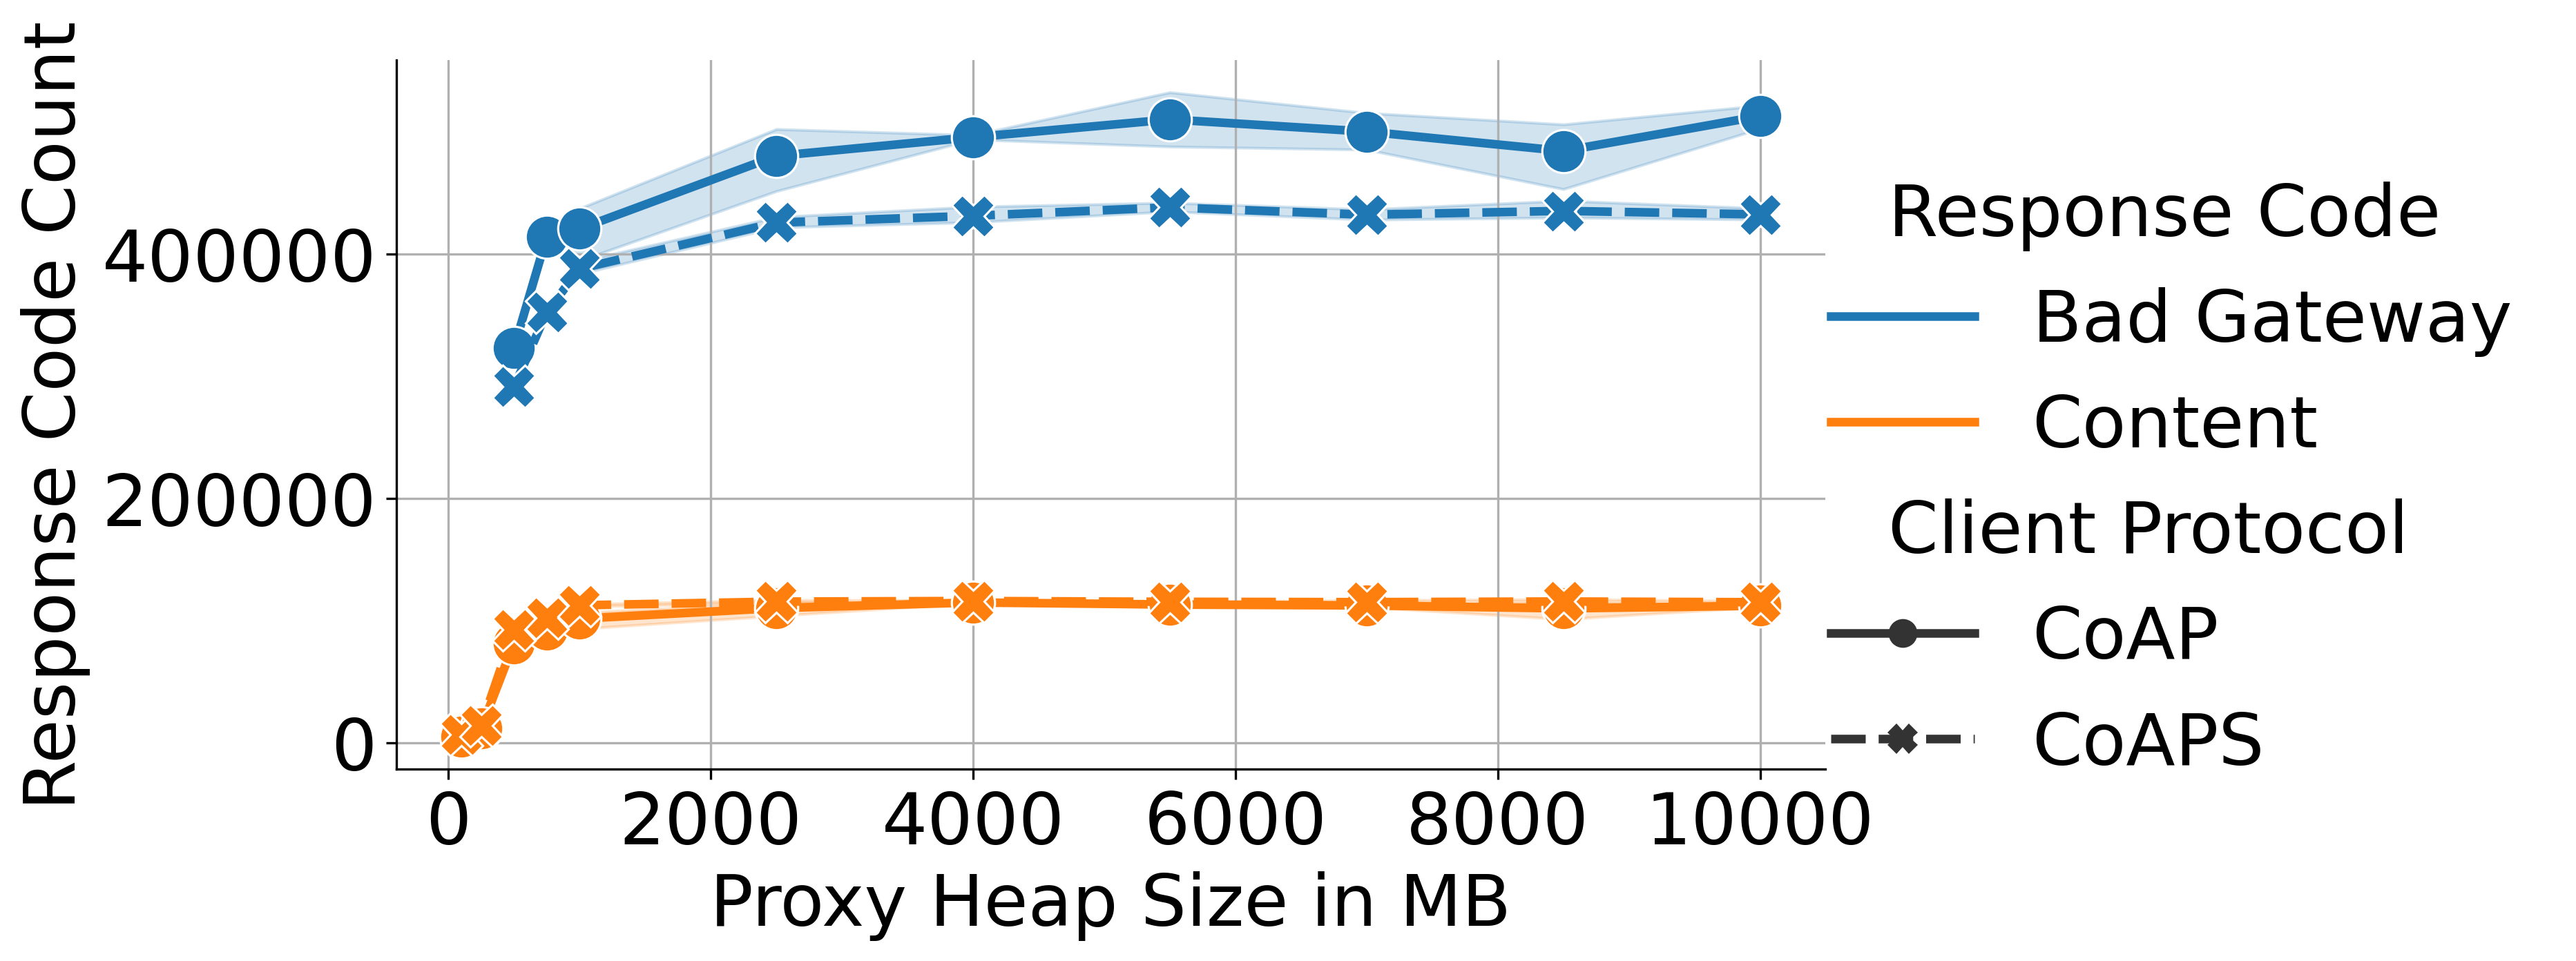

CPU times: user 2.19 s, sys: 124 ms, total: 2.31 s
Wall time: 2.02 s


exp_id  \
0    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
1    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
2    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
3    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_10000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
..                                                                                                                                               ...   
195   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
196   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
197   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
198   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
199   thesis_group_controlling_proxy_heap_size_8clients_withattacker_8500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   

     trial observer_id Response Code  response_code_count attacker_rate  \
0        1    attacker   Bad Gateway               525514       100mbps   
1        1    attacker       Content               110597       100mbps   
2        2    attacker   Bad Gateway               517247       100mbps   
3        2    attacker       Content               113466       100mbps   
4        3    attacker   Bad Gateway               512132       100mbps   
..     ...         ...           ...                  ...           ...   
195      3    attacker       Content               116608       100mbps   
196      4    attacker   Bad Gateway               429687       100mbps   
197      4    attacker       Content               118144       100mbps   
198      5    attacker   Bad Gateway               434104       100mbps   
199      5    attacker       Content               117162       100mbps   

     server_connections  max_keep_alive_requests  num_clients  num_trials  \
0                   256                        0            8           5   
1                   256                        0            8           5   
2                   256                        0            8           5   
3                   256                        0            8           5   
4                   256                        0            8           5   
..                  ...                      ...          ...         ...   
195                 256                        0            8           5   
196                 256                        0            8           5   
197                 256                        0            8           5   
198                 256                        0            8           5   
199                 256                        0            8           5   

     ...  num_proxy_connections  request_timeout  max_retries  \
0    ...                     50                5            2   
1    ...                     50                5            2   
2    ...                     50                5            2   
3    ...                     50                5            2   
4    ...                     50                5            2   
..   ...                    ...              ...          ...   
195  ...                     50     

In [71]:
%%time

df = (
  attacker_message_df
  .replace(value_map_replacement)
  .rename(columns={
    "response_code": "Response Code",
    "run_proxy_with_dtls": "Client Protocol",
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="heap_size_mb",
  y="response_code_count",
  hue="Response Code",
  style="Client Protocol",
  markers=True,
  markersize=15,
  # col="run_proxy_with_dtls",
  # col_wrap=2,
  aspect=2,
)

g.set_xlabels("Proxy Heap Size in MB")
g.set_ylabels("Response Code Count")
g.set(
  # xticks=np.arange(5,61,5),
  # yticks=np.arange(1,9,1),
)

plt.grid(True, axis="both")
plt.show()

df

In [72]:
_df = (
  df
  .groupby(
    by=["exp_id", "Response Code", "Client Protocol", "heap_size_mb"]
  )
  .agg(
    response_code_count=("response_code_count", "mean")
  )
  .reset_index()
)

total_df = (
  _df
  .groupby(
    by=["exp_id", "Client Protocol"]
  )
  .agg(
    sum_response_code_count=("response_code_count", "sum")
  )
  .reset_index()
)

_df = _df.merge(total_df, on=["exp_id", "Client Protocol"], how="left")

_df["response_code_percentage"] = round(100 * _df["response_code_count"] / _df["sum_response_code_count"], 1)

_df.sort_values(by=["heap_size_mb", "Client Protocol"])

exp_id  \
8                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_coap_https   
9                                                               thesis_group_controlling_proxy_heap_size_8clients_withattacker_100MBheap_dtls_https   
14                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_coap_https   
15                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_250MBheap_dtls_https   
20                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_coap_https   
21                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_coap_https   
22                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_dtls_https   
23                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_500MBheap_dtls_https   
32                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_coap_https   
33                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_coap_https   
34                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_dtls_https   
35                                                              thesis_group_controlling_proxy_heap_size_8clients_withattacker_750MBheap_dtls_https   
4    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
5    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
6    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
7    thesis_group_controlling_proxy_heap_size_8clients_withattacker_1000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
10   thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
11   thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
12   thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
13   thesis_group_controlling_proxy_heap_size_8clients_withattacker_2500MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
16   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
17   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
18   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
19   thesis_group_controlling_proxy_heap_size_8clients_withattacker_4000MBheap_50proxyconns_dtls_https__140sec_proxy__30sec_attacker__120sec_client   
24   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
25   thesis_group_controlling_proxy_heap_size_8clients_withattacker_5500MBheap_50proxyconns_coap_https__140sec_proxy__30sec_attacker__120sec_client   
26   thesis_group_controlling_proxy_heap_size_8clients_withattac